Altura de reflexão (Camada D): 83.4 km


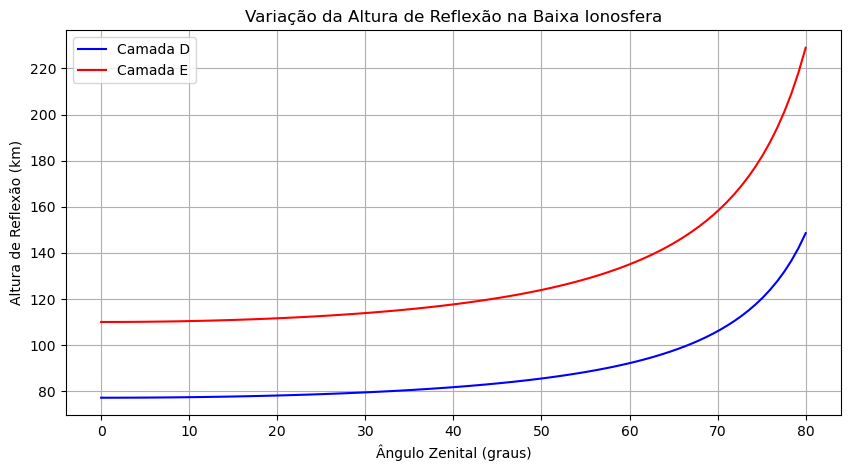

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def altura_reflexao_baixa_ionosfera(chi, phi, lambda_, camada='E'):
    """
    Calcula a altura de reflexão para a baixa ionosfera (camadas D ou E).
    
    Parâmetros:
        chi : ângulo zenital (graus)
        phi : latitude (graus)
        lambda_ : longitude (graus)
        camada : 'D' ou 'E' (padrão: 'E')
    
    Retorna:
        h_prime : altura de reflexão (km)
    """
    chi_rad = np.radians(chi)
    phi_rad = np.radians(phi)
    lambda_rad = np.radians(lambda_)
    
    # Altura base por camada
    if camada.upper() == 'D':
        h0 = 75  # km (média da camada D)
        k1, k2, k3 = 15, 5, 2
    else:  # Camada E
        h0 = 105  # km (média da camada E)
        k1, k2, k3 = 25, 10, 5
    
    # Componentes
    if chi < 85:
        delta_h_chi = k1 * (1/np.cos(chi_rad) - 1)
    else:
        delta_h_chi = np.nan
        
    # Valor inválido para ângulos muito rasantes 
    delta_h_phi = k2 * np.sin(phi_rad)**2
    delta_h_lambda = k3 * np.cos(lambda_rad - np.radians(0))  # Simplificação: lambda_0 = 0°
    
    h_prime = h0 + delta_h_chi + delta_h_phi + delta_h_lambda
    return h_prime

# Exemplo de uso
chi = 45  # Ângulo zenital (graus)
phi = -23.5  # Latitude (São Paulo)
lambda_ = -46.6  # Longitude (São Paulo)
h_D = altura_reflexao_baixa_ionosfera(chi, phi, lambda_, 'D')
h_E = altura_reflexao_baixa_ionosfera(chi, phi, lambda_, 'E')

print(f"Altura de reflexão (Camada D): {h_D:.1f} km")


chi_range = np.linspace(0, 80, 100)
h_D_range = [altura_reflexao_baixa_ionosfera(chi, phi, lambda_, 'D') for chi in chi_range]
h_E_range = [altura_reflexao_baixa_ionosfera(chi, phi, lambda_, 'E') for chi in chi_range]

plt.figure(figsize=(10, 5))
plt.plot(chi_range, h_D_range, label='Camada D', color='blue')
plt.plot(chi_range, h_E_range, label='Camada E', color='red')
plt.xlabel('Ângulo Zenital (graus)')
plt.ylabel('Altura de Reflexão (km)')
plt.title('Variação da Altura de Reflexão na Baixa Ionosfera')
plt.legend()
plt.grid(True)
plt.show()

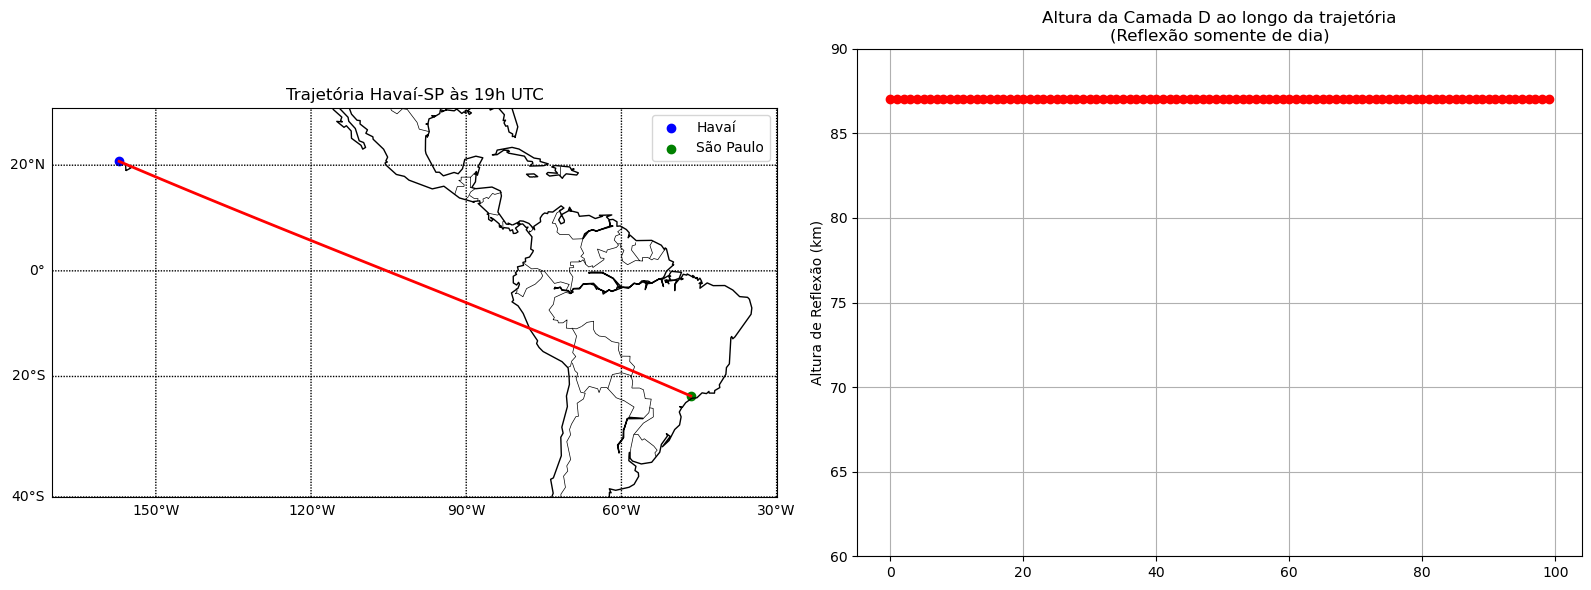


Dados da Camada D:
    Latitude   Longitude  Ângulo Zenital  Altura Reflexão D (km)
0  20.700000 -157.100000       65.181724                      87
1  20.253535 -155.983838       64.070925                      87
2  19.807071 -154.867677       62.959877                      87
3  19.360606 -153.751515       61.848769                      87
4  18.914141 -152.635354       60.737792                      87
5  18.467677 -151.519192       59.627145                      87
6  18.021212 -150.403030       58.517033                      87
7  17.574747 -149.286869       57.407668                      87
8  17.128283 -148.170707       56.299272                      87
9  16.681818 -147.054545       55.192075                      87


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import pandas as pd

# Função para calcular altura de reflexão na camada D
def altura_reflexao_D(chi, phi, lambda_, hora_utc):
    """
    Calcula a altura de reflexão na camada D (60-90 km)
    com dependência do ângulo zenital, latitude, longitude e hora UTC.
    """
    chi_rad = np.radians(chi)
    phi_rad = np.radians(phi)
    
    # Parâmetros específicos para a camada D
    h0 = 75  # Altura base (km)
    k1, k2, k3 = 15, 5, 2  # Coeficientes ajustados para a camada D
    
    # Correção diurna (a camada D desaparece à noite)
    if 6 <= hora_utc <= 18:  # Dia
        if chi < 85:
            delta_h_chi = k1 * (1/np.cos(chi_rad) - 1)
        else:
            delta_h_chi = 90
    else:  # Noite
        return 87  # Sem reflexão na camada D à noite
    
    delta_h_phi = k2 * np.sin(phi_rad)**2
    delta_h_lambda = k3 * np.cos(np.radians(lambda_ - hora_utc*15))  # Variação com longitude solar
    
    altura = h0 + delta_h_chi + delta_h_phi + delta_h_lambda
    return np.clip(altura, 60, 87)  # Limita à faixa da camada D

# Função para calcular ângulo zenital solar
def calcular_zenital(lat, lon, hora_utc, data):
    """
    Calcula o ângulo zenital solar considerando:
    - Latitude e longitude do local
    - Hora UTC
    - Data do ano
    Retorna o ângulo zenital em graus
    """
    # Converter para radianos
    lat_rad = np.radians(lat)
    
    # Dia do ano (1-365)
    dia_ano = data.timetuple().tm_yday
    
    # Declinação solar (aproximação)
    declinacao = 23.45 * np.sin(np.radians(360 * (284 + dia_ano) / 365))
    declinacao_rad = np.radians(declinacao)
    
    # Hora solar local
    hora_local = hora_utc + lon/15
    hora_solar = (hora_local - 12) * 15  # Ângulo horário em graus
    hora_solar_rad = np.radians(hora_solar)
    
    # Cálculo do ângulo zenital
    cos_zenital = (np.sin(lat_rad) * np.sin(declinacao_rad) + 
                  np.cos(lat_rad) * np.cos(declinacao_rad) * np.cos(hora_solar_rad))
    
    zenital = np.degrees(np.arccos(cos_zenital))
    return zenital

# Trajetória Havaí (-157.1°W, 20.7°N) até São Paulo (-46.6°W, 23.5°S)
n_points = 100
lons = np.linspace(-157.1, -46.6, n_points)
lats = np.linspace(20.7, -23.5, n_points)
hora_utc = 19  # 17h UTC
data = datetime(2023, 1, 22)

# Cálculos
zenitals = [calcular_zenital(lat, lon, hora_utc,data) for lat, lon in zip(lats, lons)]
alturas_D = [altura_reflexao_D(chi, lat, lon, hora_utc) for chi, lat, lon in zip(zenitals, lats, lons)]

# Plotagem
plt.figure(figsize=(16, 6))

# Mapa
plt.subplot(121)
m = Basemap(projection='merc', llcrnrlat=-40, urcrnrlat=30,
            llcrnrlon=-170, urcrnrlon=-30, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawparallels(np.arange(-40, 41, 20), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180, 181, 30), labels=[0,0,0,1])

x, y = m(lons, lats)
m.plot(x, y, 'r-', linewidth=2)
m.scatter(x[0], y[0], c='b', label='Havaí')
m.scatter(x[-1], y[-1], c='g', label='São Paulo')
plt.title(f'Trajetória Havaí-SP às {hora_utc}h UTC')
plt.legend()

# Gráfico das alturas
plt.subplot(122)
valid_points = ~np.isnan(alturas_D)
plt.plot(np.arange(n_points)[valid_points], np.array(alturas_D)[valid_points], 'r-o')
#plt.xticks([0, n_points//2, n_points-1], ['Havaí', 'Meio Caminho', 'São Paulo'])
plt.ylabel('Altura de Reflexão (km)')
plt.ylim(60, 90)
plt.title('Altura da Camada D ao longo da trajetória\n(Reflexão somente de dia)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Tabela de dados
df = pd.DataFrame({
    'Latitude': lats,
    'Longitude': lons,
    'Ângulo Zenital': zenitals,
    'Altura Reflexão D (km)': alturas_D
})
print("\nDados da Camada D:")
print(df.head(10))